# RAG Workshop Notebook

**TDWI 2025 ‚Äì Hands‚Äëon Session**

Dieses Notebook f√ºhrt dich Schritt f√ºr Schritt durch den kompletten RAG-Workflow:

1. **Setup & Ziele**: Umgebung vorbereiten, Lernziele verstehen
# Index Pipeline
2. **Daten laden**: Beispiel-HTML abrufen  
3. **Chunking**: Token- vs. rekursives Splitten  
4. **Embeddings**: Hugging Face vs. OpenAI + Kosten  
# Vektorspeicher
5. **Indexing**: Vektorspeicherung (FAISS, pgvector)
# RAG Pipeline
6. **Augmentation**: Anreicherung des Prompts
7. **Retrieval**: Anfrage / Chat mit LLM
8. **Evaluierung**: Precision/Recall

> üí° *Tipp:* Nutze das Jupyter/Colab‚ÄëTOC‚ÄëPlugin oder ‚ÄúEin-/Ausklappen‚Äù, um schnell zu navigieren.

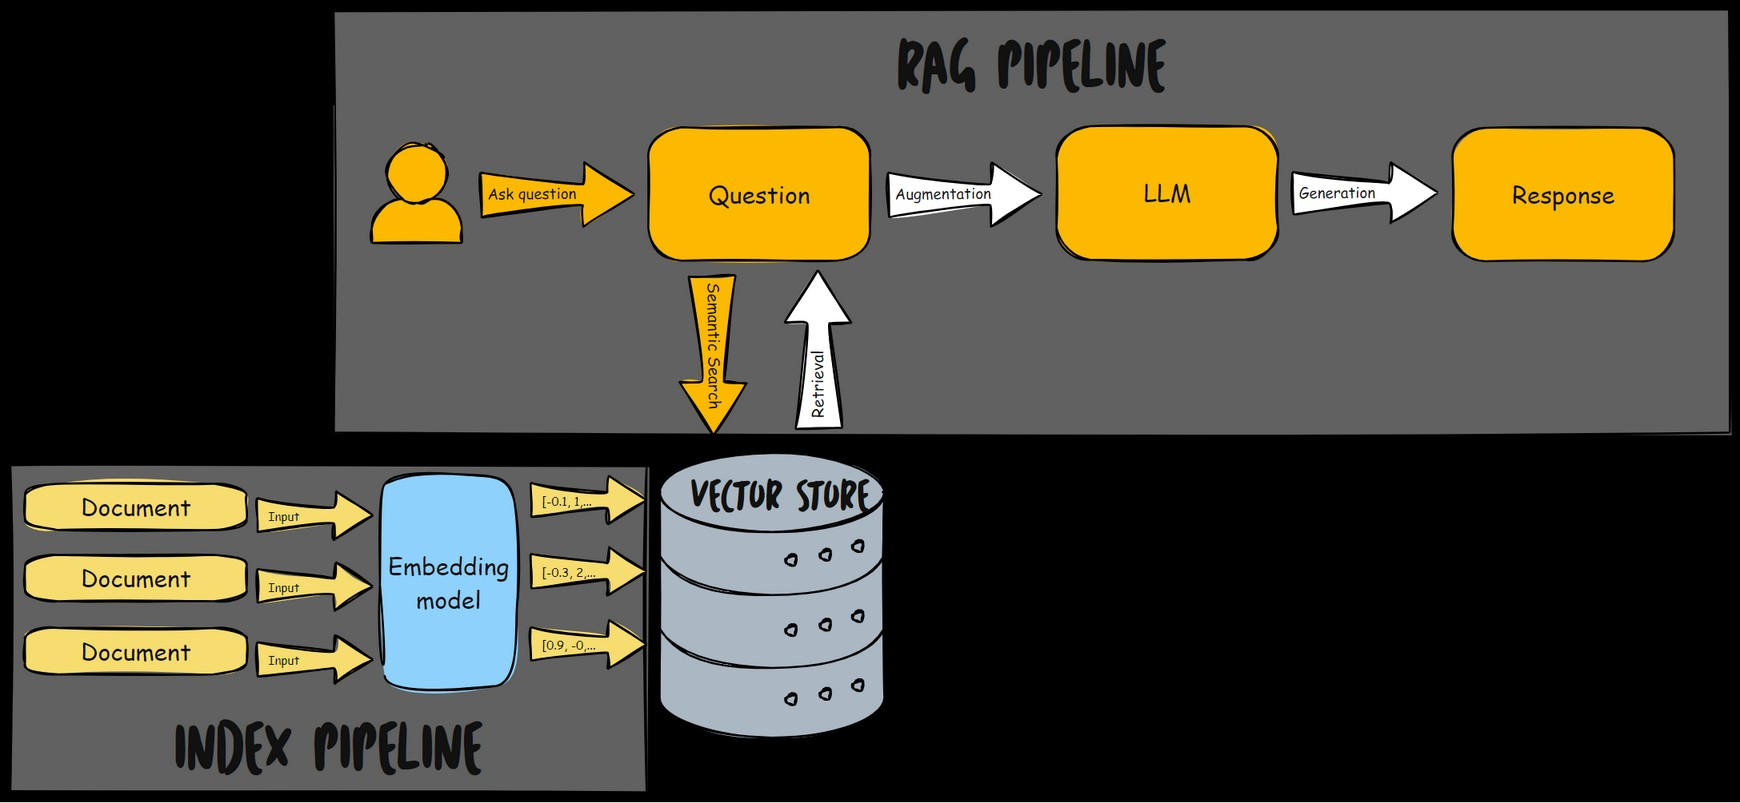


### Lernziele
Nach diesem Notebook kannst du ‚Ä¶

1. die Kernidee hinter Retrieval‚ÄëAugmented Generation (RAG) erkl√§ren,
2. Beispiel-Webdaten laden und inspizieren,
3. Semantische Suche in Vektordatenbanken/indexes durchf√ºhren.

Du kannst das Notebook in Google Colab ausf√ºhren oder lokal auf deinem eigenen Notebook.
### Voraussetzungen
* Google Colab (frei verf√ºgbare Notebook Umgebung)
* Optional OpenAI- und/oder HuggingFace-Account
Zus√§tzliche Voraussetzungen bei lokaler Ausf√ºhrung
* Python ‚â• 3.12  
* `pip install -r requirements.txt` f√ºr die lokale Python Umgebung
* Falls PostgreSQL pgvector genutzt werden soll: lokale Docker/podman Installation

### Ablauf - grober √úberblick
| Abschnitt | Zeit | Inhalt |
|-----------|------|--------|
| Setup (dieses Notebook) | 10 min | Umgebung, Datenquellen, Key-Handling |
| Daten laden | 10 min | Wiki Seite abrufen |
| Chunking | 15 min | Text in H√§ppchen |
| Embedding | 10 min | Vektorisierung & Kosten |
| Indexing | 15 min | Vektor-Datenbanken |
| Augmentation & Retrieval | 15 min | Daten anreichern und Chat |
| Evaluierung & Extras | 5 min | Metriken, RAG-Chains |

# 01 Setup
In diesem Abschnitt installieren wir Abh√§ngigkeiten, importieren Libraries und definieren globale Konstanten.

### Schritt¬†01-01 ‚Äì Python Pakete installieren
In google colab requirements.txt zuerst nach content kopieren

In [7]:
import sys
import subprocess
from pathlib import Path

is_colab  = "google.colab" in sys.modules
req_path  = Path("requirements.txt") if is_colab else Path("..") / "requirements.txt"
python_exe = sys.executable

subprocess.check_call(
    [python_exe, "-m", "pip", "install", "-r", str(req_path), "--no-cache-dir"]
)

0

In [8]:
import os, pathlib, sys
print("Arbeitsverzeichnis:", os.getcwd())
print("Python-Version    :", sys.version.split()[0])
print("Inhalt:", list(pathlib.Path().iterdir())[:5])

Arbeitsverzeichnis: /content
Python-Version    : 3.11.13
Inhalt: [PosixPath('.config'), PosixPath('requirements.txt'), PosixPath('sample_data')]


### Schritt 01-02 ‚Äì Import der Python Pakete und initiale Einstellungen

In [9]:
# Import and initial settings

import warnings
import textwrap
import copy
from langchain_community.document_loaders import AsyncHtmlLoader
from langchain_community.document_transformers import BeautifulSoupTransformer

from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain_text_splitters import HTMLSectionSplitter

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import OpenAIEmbeddings

# Ignore all warnings
warnings.filterwarnings("ignore")

### Schritt 01-03 ‚Äì Konfigurationen

In [10]:
# Link zur Wikipedia-Seite, die verarbeitet wird
url = "https://en.wikipedia.org/wiki/Retrieval-augmented_generation"

# 02 Daten laden
In diesem Abschnitt laden wir die Wiki-Seite.

### Schritt 02-01 ‚Äì Abrufen der Wiki-Seite

In [11]:
# Die Wiki-Seite wird gelesen in die Variable html_ori_page.
# Diese Variable enth√§lt
# - Metadaten
# - Nutzdaten ("Wikiseite") inklusive html-Tags. Die Nutzdaten m√ºssen im weiteren Verlauf bereinigt werden ("Cleansing").
HTMLloader = AsyncHtmlLoader (url)

html_page_ori = HTMLloader.load()


Fetching pages: 100%|##########| 1/1 [00:00<00:00, 19.25it/s]


### Schritt 02-02 ‚Äì Metadaten pr√ºfen/anzeigen

In [12]:
html_page = copy.deepcopy(html_page_ori)
print(html_page[0].metadata)

{'source': 'https://en.wikipedia.org/wiki/Retrieval-augmented_generation', 'title': 'Retrieval-augmented generation - Wikipedia', 'language': 'en'}


### Schritt 02-03 ‚Äì Nutzdaten pr√ºfen/anzeigen

In [13]:
# Es werden die ersten 1000 Zeichen angezeigt
# und mit Hilfe von textwrap "umgebrochen" statt einer langen Zeile
html_page = copy.deepcopy(html_page_ori)
content = html_page[0].page_content[:1000]
wrapped = textwrap.fill(content, width=80)

print(wrapped)

<!DOCTYPE html> <html class="client-nojs vector-feature-language-in-header-
enabled vector-feature-language-in-main-page-header-disabled vector-feature-
page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-
feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1
vector-feature-limited-width-content-enabled vector-feature-custom-font-size-
clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-
mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-
available" lang="en" dir="ltr"> <head> <meta charset="UTF-8"> <title>Retrieval-
augmented generation - Wikipedia</title> <script>(function(){var
className="client-js vector-feature-language-in-header-enabled vector-feature-
language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled
vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled
vector-feature-limited-width-clientpref-1 vector-feature-limited-width-con

### Schritt 02-04 ‚Äì Cleansing
Das Dokument beinhaltet html-Tags, die bereinigt werden m√ºssen.
Dazu wird transform_documents aufgerufen. transform_documents √§ndert die Originaldaten, daher wird zuerst eine Kopie angelegt: transform_docuemnts kann deswegen nur einmalig aufgerufen werden. Durch das Anlegen der Kopie k√∂nnen Zellen im Notebook mehrfach aufgerufen werden und ist somit fehlertoleranter.

In [14]:
soup_transformer = BeautifulSoupTransformer()

html_page = copy.deepcopy(html_page_ori)
html_page_transformed = soup_transformer.transform_documents(html_page, tags_to_extract=["p"])

### Schrittm 02-05 ‚Äì Metadaten pr√ºfen/anzeigen

In [15]:
print(html_page_transformed[0].metadata)

{'source': 'https://en.wikipedia.org/wiki/Retrieval-augmented_generation', 'title': 'Retrieval-augmented generation - Wikipedia', 'language': 'en'}


### Schritt 02-06 ‚Äì Nutzdaten pr√ºfen/anzeigen

In [16]:
content = html_page_transformed[0].page_content[:5000]
wrapped = textwrap.fill(content, width=80)

print(wrapped)

Retrieval-augmented generation ( RAG ) is a technique that enables large
language models (/wiki/Large_language_model) (LLMs) to retrieve and incorporate
new information. [ 1 (#cite_note-:1-1) ] With RAG, LLMs do not respond to user
queries until they refer to a specified set of documents. These documents
supplement information from the LLM's pre-existing training data
(/wiki/Training_data) . [ 2 (#cite_note-:2-2) ] This allows LLMs to use domain-
specific and/or updated information that is not available in the training data.
[ 2 (#cite_note-:2-2) ] [ 3 (#cite_note-:4-3) ] For example, this helps LLM-
based chatbots (/wiki/Chatbot) access internal company data or generate
responses based on authoritative sources. RAG improves large language models
(LLMs) by incorporating information retrieval (/wiki/Information_retrieval)
before generating responses. [ 4 (#cite_note-:5-4) ] Unlike traditional LLMs
that rely on static training data, RAG pulls relevant text from databases,
uploaded docume

# 03 Chunking

### Theorie: Warum Chunking?
Large-Language-Modelle haben ein Kontextlimit (z.&nbsp;B. 128k Tokens bei GPT-4o). Ein langer Artikel muss daher in kleinere Teile (‚ÄûChunks‚Äú) zerlegt werden. Die Wahl der Chunk-Gr√∂√üe und des Overlaps beeinflusst die Qualit√§t der Ergebnisse.
Das Kontextlimit wird immer gr√∂√üer. Trotzdem ist ein Chunking sinnvoll, denn je gr√∂√üer der Text (Chunk) ist, umso mehr gehen relevante, spezifische Inhalte verloren.

Es gibt eine Vielzahl von Chunking-M√∂glichkeiten:
* **Fixed Length** (z.&nbsp;B. 1000 Zeichen) ‚Äì simpel, aber ignoriert Satzgrenzen  
* **Token-basiert** ‚Äì pr√§ziser, braucht `tiktoken`  
* **Rekursives Splitten** ‚Äì beh√§lt semantische Einheiten (Abs√§tze, S√§tze)

???????????????
#### ‚úèÔ∏è Aufgabe¬†1¬†‚Äì Chunk‚ÄëGr√∂√üe variieren
1. Setze `max_chunk_size` auf **256, 512, 1024 Tokens**.  
2. Miss die **Anzahl der Chunks** und plotte ein Histogramm.  
3. Welche Einstellung liefert den besten Kompromiss aus *Kontext* und *Recall*?

> üí° *Nutze die leere Code‚ÄëZelle unter ‚Äû# YOUR CODE HERE‚Äú.*  


### Schritt 03-01 ‚Äì Anzahl Zeichen der Webseite

In [17]:
print(len(html_page_transformed[0].page_content))

11534


Basis Chunking by number of characters

### Schritt 03-02 ‚Äì Fixed Length Chunking
Einfaches Chunking anhand fixer Gr√∂√üen mit/ohne √úberlappung von Zeichen.

In [18]:
text_splitter = CharacterTextSplitter(
separator=" ",               # Zeichen f√ºr das Trennen des Textes
chunk_size=1000,             # Anzahl Zeichen im Chunk
chunk_overlap=0,             # Anzahl √ºberlappende Zeichen; wiederhole die n√§chsten Schritte mit anderen Werten, z.B. 0 oder 50
)

text_chunks=text_splitter.create_documents([html_page_transformed[0].page_content])

print(f"Anzahl Chunks, die erzeugt wurden: {len(text_chunks)}")

Anzahl Chunks, die erzeugt wurden: 12


### Schritt 03-03 ‚Äì Chunks pr√ºfen/anzeigen (1 von 2)

In [19]:
# vergleiche die letzten Zeichen von Chunk 4 mit den ersten Zeichen von Chunk 5

content = text_chunks[4].page_content
wrapped = textwrap.fill(content, width=80)

print(wrapped)

responses" ( indexing ). [ 10 (#cite_note-AWS-10) ] This approach reduces
reliance on static datasets, which can quickly become outdated. When a user
submits a query, RAG uses a document retriever to search for relevant content
from available sources before incorporating the retrieved information into the
model‚Äôs response ( retrieval ). [ 11 (#cite_note-:9-11) ] Ars Technica notes
that "when new information becomes available, rather than having to retrain the
model, all that‚Äôs needed is to augment the model‚Äôs external knowledge base with
the updated information" ( augmentation ). [ 6 (#cite_note-:0-6) ] By
dynamically integrating relevant data, RAG enables LLMs to generate more
informed and contextually grounded responses ( generation ). [ 5
(#cite_note-:7-5) ] IBM states that "in the generative phase, the LLM draws from
the augmented prompt and its internal representation of its training data to
synthesize an engaging answer tailored to the user in that instant. [ 1
(#cite_note-

### Schritt 03-03 ‚Äì Chunks pr√ºfen/anzeigen (2 von 2)

In [20]:
content = text_chunks[5].page_content
wrapped = textwrap.fill(content, width=80)

print(wrapped)

] Typically, the data to be referenced is converted into LLM embeddings
(/wiki/Word_embeddings) , numerical representations in the form of a large
vector space. [ 8 (#cite_note-:8-8) ] RAG can be used on unstructured (usually
text), semi-structured, or structured data (for example knowledge graphs
(/wiki/Knowledge_graphs) ). [ 12 (#cite_note-Survey-12) ] These embeddings are
then stored in a vector database (/wiki/Vector_database) to allow for document
retrieval (/wiki/Document_retrieval) . [ 13 (#cite_note-:10-13) ] Given a user
query, a document retriever is first called to select the most relevant
documents that will be used to augment the query. [ 2 (#cite_note-:2-2) ] [ 4
(#cite_note-:5-4) ] This comparison can be done using a variety of methods,
which depend in part on the type of indexing used. [ 1 (#cite_note-:1-1) ] [ 12
(#cite_note-Survey-12) ] The model feeds this relevant retrieved information
into the LLM via prompt engineering (/wiki/Prompt_engineering) of the user's


### Schritt 03-04 - Verteilung der Anzahl Zeichen von Minimum bis Maximum

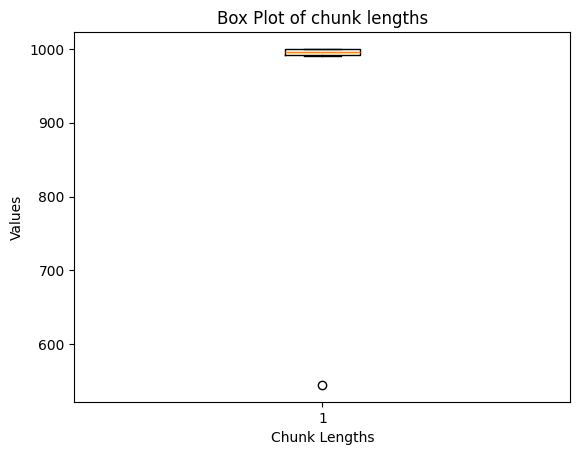

The median chunk length is : 996.0
The average chunk length is : 958.58
The minimum chunk length is : 545
The max chunk length is : 1000
The 75th percentile chunk length is : 999.25
The 25th percentile chunk length is : 991.75


In [21]:
import matplotlib.pyplot as plt
import numpy as np


data = [len(doc.page_content) for doc in text_chunks]

plt.boxplot(data)
plt.title('Box Plot of chunk lengths')
plt.xlabel('Chunk Lengths')
plt.ylabel('Values')

plt.show()

print(f"The median chunk length is : {round(np.median(data),2)}")
print(f"The average chunk length is : {round(np.mean(data),2)}")
print(f"The minimum chunk length is : {round(np.min(data),2)}")
print(f"The max chunk length is : {round(np.max(data),2)}")
print(f"The 75th percentile chunk length is : {round(np.percentile(data, 75),2)}")
print(f"The 25th percentile chunk length is : {round(np.percentile(data, 25),2)}")

### Schritt 03-05 ‚Äì Rekursives Splitten
Verbessertes Chunking anhand thematischer Einheiten, z.B. √úberschriften oder Tabellen in einer html-Seite.

In [22]:
sections_to_split_on = [
     ("h1", "Header 1"),
     ("h2", "Header 2"),
     ("h3", "Header 3"),
     ("table","Table"),
     #("div", "Div"),
     #("img","Image"),
     #("p","P"),
]

splitter = HTMLSectionSplitter(sections_to_split_on)

html_page = copy.deepcopy(html_page_ori)
split_content = splitter.split_text(html_page[0].page_content)

### Schritt 03-06 - Anzahl Chunks pr√ºfen/anzeigen

In [23]:
len(split_content)

22

### Schritt 03-07 - erste 10 Chunks pr√ºfen/anzeigen

In [24]:
# Look into the first 10 chunks
split_content[:10]

[Document(metadata={'Header 1': '#TITLE#'}, page_content='Jump to content \n \n \n \n \n \n \n \n Main menu \n \n \n \n \n \n Main menu \n move to sidebar \n hide \n \n \n \n\t\tNavigation\n\t \n \n \n Main page \n Contents \n Current events \n Random article \n About Wikipedia \n Contact us \n \n \n \n \n \n\t\tContribute\n\t \n \n \n Help \n Learn to edit \n Community portal \n Recent changes \n Upload file \n Special pages \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n Search \n \n \n \n \n \n \n \n \n \n \n \n Search \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n Appearance \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n Donate \n \n \n Create account \n \n \n Log in \n \n \n \n \n \n \n \n \n Personal tools \n \n \n \n \n \n Donate \n   Create account \n   Log in \n \n \n \n \n \n\t\tPages for logged out editors  learn more \n \n \n \n Contributions \n Talk \n \n \n \n \n \n \n \n \n \n \n \n \n  CentralNotice'),
 Document(metadata={'Header

### Schritt 03-08 ‚Äì Chunks per Abschnitt pr√ºfen/anzeigen
Abschnitte sind z.B. √úberschriften 1., 2., 3. Ebene, Tabellen oder andere html-Abschnitte.

In [25]:
from collections import Counter

class_counter = Counter()

for doc in split_content:
    document_class = next(iter(doc.metadata.keys()))
    class_counter[document_class] += 1

print(class_counter)

Counter({'Header 3': 8, 'Header 2': 6, 'Table': 6, 'Header 1': 2})


### Schritt 03-09 - Verteilung der Anzahl Zeichen von Minimum bis Maximum

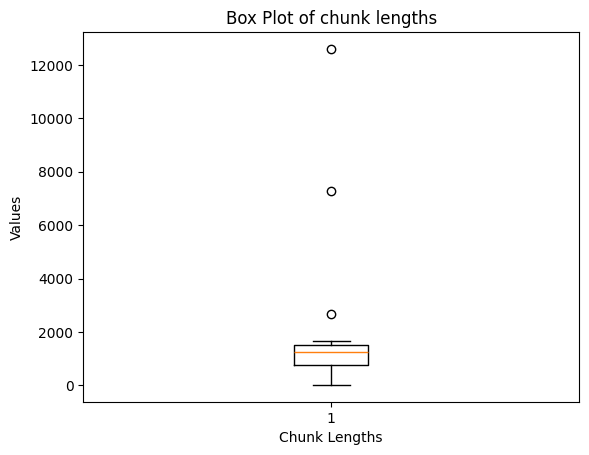

The median chunk lenght is : 1233.5
The average chunk lenght is : 1912.09
The minimum chunk lenght is : 19
The max chunk lenght is : 12595
The 75th percentile chunk length is : 1501.0
The 25th percentile chunk length is : 761.5


In [26]:
data = [len(doc.page_content) for doc in split_content]

plt.boxplot(data)
plt.title('Box Plot of chunk lengths')
plt.xlabel('Chunk Lengths')
plt.ylabel('Values')

plt.show()

print(f"The median chunk lenght is : {round(np.median(data),2)}")
print(f"The average chunk lenght is : {round(np.mean(data),2)}")
print(f"The minimum chunk lenght is : {round(np.min(data),2)}")
print(f"The max chunk lenght is : {round(np.max(data),2)}")
print(f"The 75th percentile chunk length is : {round(np.percentile(data, 75),2)}")
print(f"The 25th percentile chunk length is : {round(np.percentile(data, 25),2)}")

### Schritt 03-10 - Verteilung der Anzahl Zeichen √§ndern
In der n√§chsten Zelle werden die Anzahl Zeichen limitiert, so dass die Ungleichverteilung reduziert wird.

In [27]:
# Now have an upper limit of 1000 for number of characters in each chunk
text_splitter = RecursiveCharacterTextSplitter(
separators=[" ","\n","."],   # Zeichen f√ºr das Trennen des Textes
chunk_size=5000,             # Anzahl Zeichen im Chunk
chunk_overlap=50,            # Anzahl √ºberlappende Zeichen; wiederhole die n√§chsten Schritte mit anderen Werten, z.B. 0 oder 50
)

final_chunks=text_splitter.split_documents(split_content)

print(f"Anzahl Chunks, die erzeugt wurden: {len(final_chunks)}")

Anzahl Chunks, die erzeugt wurden: 25


### Schritt 03-11 - Verteilung der Anzahl Zeichen von Minimum bis Maximum

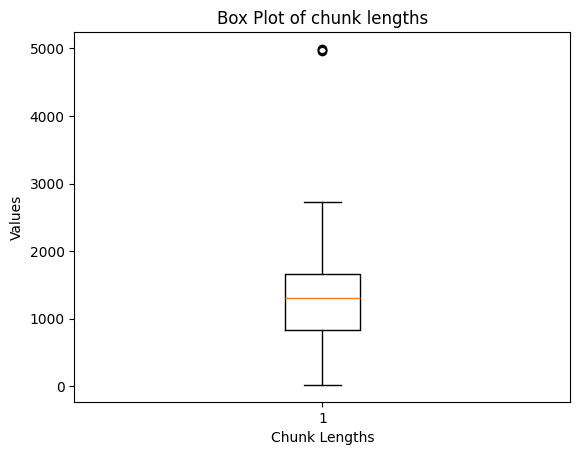

The median chunk lenght is : 1302.0
The average chunk lenght is : 1687.32
The minimum chunk lenght is : 19
The max chunk lenght is : 4993
The 75th percentile chunk length is : 1664.0
The 25th percentile chunk length is : 829.0


In [28]:
data = [len(doc.page_content) for doc in final_chunks]

plt.boxplot(data)
plt.title('Box Plot of chunk lengths')  # Title
plt.xlabel('Chunk Lengths')  # Label for x-axis
plt.ylabel('Values')  # Label for y-axis

plt.show()

print(f"The median chunk lenght is : {round(np.median(data),2)}")
print(f"The average chunk lenght is : {round(np.mean(data),2)}")
print(f"The minimum chunk lenght is : {round(np.min(data),2)}")
print(f"The max chunk lenght is : {round(np.max(data),2)}")
print(f"The 75th percentile chunk length is : {round(np.percentile(data, 75),2)}")
print(f"The 25th percentile chunk length is : {round(np.percentile(data, 25),2)}")

# 04 Embeddings

### Embeddings: HF vs. OpenAI
| Provider | Modell | Dim | Kosten ($ / 1K tokens) | Hinweis |
|----------|--------|-----|------------------------|---------|
| HF (open‚Äësource) | `nomic-embed-text` | 768 | 0 (lokal) | Braucht GPU / >8‚ÄØGB VRAM |
| OpenAI | `text-embedding-3-small` | 1536 | 0.00002 | Schnell, Cloud-Kosten |

**Kostenformel**

\[
\text{Kosten} = \frac{\text{Tokens}}{1000} \times \text{Price}

#### ‚úèÔ∏è Aufgabe¬†2¬†‚Äì Kostenvergleich
1. Berechne Tokens einer Beispielseite mit `tiktoken`.  
2. Vergleiche die Kosten beider Modelle bei gleicher Dokumentenmenge.  
3. Diskutiere, wann Open‚ÄëSource vs. SaaS sinnvoll ist.

### Schritt 04-01 ‚Äì Open Source Embedding Modell Hugging Face

In [30]:
if is_colab:
  from google.colab import userdata
  api_key_openai = userdata.get('OPENAI_API_KEY')
  api_key_hf = userdata.get("HF")
  api_key_gemini = userdata.get("GEMINI")
else:
  from pathlib import Path
  from dotenv import load_dotenv, find_dotenv
  import os
  load_dotenv(find_dotenv())
  api_key_openai = os.getenv("OPENAI_API_KEY")
  api_key_hf = os.getenv("HF")
  api_key_gemini = os.getenv("GEMINI")

In [31]:
from huggingface_hub import logout, login
logout()                       # "nicht aufgeraeumte Token entfernen, um 401-Fehler vermeiden
login(api_key_hf)

embeddings_os = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

hf_embeddings_os = embeddings_os.embed_documents([chunk.page_content for chunk in final_chunks])

Not logged in!


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Schritt 04-02 - Embeddings pr√ºfen/anzeigen

In [32]:
print(f"L√§nge des Embedding Vektors ist {len(hf_embeddings_os[0])}")
print(f"Das Embedding Objekt ist ein Array mit Anzahl Zeilen (Anzahl Chunks) X Vektorl√§nge {len(hf_embeddings_os)} X {len(hf_embeddings_os[0])}")

L√§nge des Embedding Vektors ist 768
Das Embedding Objekt ist ein Array mit Anzahl Zeilen (Anzahl Chunks) X Vektorl√§nge 25 X 768


### Schritt 04-03 ‚Äì OpenAI Embedding Modell
Einen API Key unter https://platform.openai.com/settings/organization/api-keys erzeugen. Den API Key dann unter Secrets (Colab Notebook) mit dem Namen OPENAI_API_KEY eingeben und f√ºr den Notebook-Zugriff freigeben. Achtung: der Zugriff erzeugt Kosten. Ein ChatGPT Abo reicht nicht, es muss ein Guthaben vorhanden sein.

In [33]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small",
                              openai_api_key=api_key_openai )

openai_embeddings = embeddings.embed_documents([chunk.page_content for chunk in final_chunks])


Schritt 04-04 - Embeddings pr√ºfen/anzeigen

In [34]:
print(f"L√§nge des Embedding Vektors ist {len(openai_embeddings[0])}")
print(f"Das Embedding Objekt ist ein Array mit Anzahl Zeilen (Anzahl Chunks) X Vektorl√§nge {len(openai_embeddings)} X {len(openai_embeddings[0])}")

L√§nge des Embedding Vektors ist 1536
Das Embedding Objekt ist ein Array mit Anzahl Zeilen (Anzahl Chunks) X Vektorl√§nge 25 X 1536


# 05 Indexing
Speicherung der Vektoren in einer Datenbank (z.B. PostgreSQL pgvector, Qdrant, Chroma, Milvus, Oracle, etc) oder einem Vektroindex (z.B. FAISS "Facebook AI Similarity Search").
Eine Datenbank kann neben den Vektoren auch die Nutzdaten speichern

### Schritt 05-01 FAISS installieren

### Schritt 05-02 FAISS konfigurieren und Vektoren erzeugen

In [35]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

index = faiss.IndexFlatIP(len(hf_embeddings_os[0]))

vector_store = FAISS(
    embedding_function=embeddings_os,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

vector_store.add_documents(documents=final_chunks)

['0dbdddd3-91f0-45f5-8c56-80d59e9ba931',
 '6e3e32bf-3eb1-4323-9606-97dcea5ea2fe',
 '78ca657f-d5ae-4b79-9ca3-02f149786130',
 'b93da2b3-a8cb-43a5-9fbb-2c91e00c6306',
 '595b8275-7945-4b69-a60c-c00a2d959e3c',
 '279f95b1-ac13-46b5-865e-812ce555d9d1',
 '90227464-914d-423f-b453-d0adc00019f1',
 '2e5795ee-1bbf-42ca-8730-ebf3704cb8c4',
 '1438a721-694b-44c3-b2e5-1fad4130933e',
 '1affbe26-975a-4e48-b5cd-eb5869262aa2',
 'd1d89062-206c-43ce-aba6-76287946d153',
 '57b47423-0532-4539-baff-4bcc1a4b5609',
 '04cea8aa-872a-4583-8520-f90c5e59f369',
 '35f747a6-4072-44ea-8c87-e6cb9c04246d',
 'd97f194a-5350-4540-9d0a-7f6de3dd8eaa',
 '24ffb70e-b02e-4d4e-9995-fcf5bc8011b0',
 '4dcc588b-6d74-49cf-b73e-68157dcb136c',
 '7f1f1b80-83a6-455c-87e5-a5f964215172',
 'fcb02cbe-de05-48aa-9cac-4645eefe6d68',
 '98d3e9ff-0209-4932-b88a-55526386c299',
 '7c544b87-e4af-4ae1-b4eb-0a4e15383533',
 'a925f7e3-a0d8-420f-ac0e-b006c6ebc4ca',
 '5d8e0e44-f607-461d-9aa7-03b52d77fe8f',
 '6e9d7403-5262-454d-888c-1db036c23db4',
 'de16e1f5-4882-

### Schritt 05-02 - FAISS Index speichern

In [ ]:
vector_store.save_local(folder_path="Data",index_name="Wiki_index")

### Schritt 05-03 - √Ñhnlichkeitssuche im FAISS Index
In der Vektordatenbank/Vektorindex wird eine √Ñhnlichkeitssuche durchgef√ºhrt und das √§hnlichste Dokument wird angezeigt.

In [36]:
query = "What are key stages?"

docs = vector_store.similarity_search(query)

print(docs[0].page_content)

RAG key stages 
 [ edit ] 
 
 
 Indexing 
 [ edit ] 
 
 Typically, the data to be referenced is converted into LLM  embeddings , numerical representations in the form of a large vector space. [ 8 ]  RAG can be used on unstructured (usually text), semi-structured, or structured data (for example  knowledge graphs ). [ 12 ]  These embeddings are then stored in a  vector database  to allow for  document retrieval . [ 13 ] 
 
 Overview of RAG process, combining external documents and user input into an LLM prompt to get tailored output 
 
 Retrieval 
 [ edit ] 
 
 Given a user query, a document retriever is first called to select the most relevant documents that will be used to augment the query. [ 2 ] [ 4 ]  This comparison can be done using a variety of methods, which depend in part on the type of indexing used. [ 1 ] [ 12 ] 
 
 
 Augmentation 
 [ edit ] 
 
 The model feeds this relevant retrieved information into the LLM via  prompt engineering  of the user's original query. [ 10 ] [ 14

### Schritt 05-04 DuckDB konfigurieren und Vektoren erzeugen
Achtung: die Daten werden nicht lokal gespeichert (fehlende Funktionalit√§t?)

In [37]:
# https://api.python.langchain.com/en/latest/vectorstores/langchain_community.vectorstores.duckdb.DuckDB.html
from langchain_community.vectorstores import DuckDB

try:
    vector_store_duckDB = DuckDB.from_documents(
        documents=final_chunks,
        embedding=embeddings_os,
        persist_path="duckdb_vectors.duckdb"
    )

    print("Vector store created successfully.")
except Exception as e:
    print("Error during creation:", e)



Vector store created successfully.


### Schritt 05-05 - √Ñhnlichkeitssuche in DuckDB

In [38]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# noch nicht implementiert in DuckDB
# similarity_search_with_relevance_scores (query, k=3)
# Daher etwas aufw√§ndiger:

# Embedding erstellen
query_embedding = embeddings_os.embed_query(query)

# top-k Dokumente/Chunks abrufen
docs = vector_store_duckDB.similarity_search(query, k=3)

# √Ñhnlichkeitsma√ü manuell berechnen
for i, doc in enumerate(docs):
    doc_embedding = embeddings_os.embed_query(doc.page_content)
    similarity = cosine_similarity(
        np.array(query_embedding).reshape(1, -1),
        np.array(doc_embedding).reshape(1, -1)
    )[0][0]

    print(f"\nErgebnis #{i+1}")
    print(f"√Ñhnlichkeit (similarity): {similarity:.4f}")
    print(f"Inhalt:\n{doc.page_content}")


Ergebnis #1
√Ñhnlichkeit (similarity): 0.2145
Inhalt:
RAG key stages 
 [ edit ] 
 
 
 Indexing 
 [ edit ] 
 
 Typically, the data to be referenced is converted into LLM  embeddings , numerical representations in the form of a large vector space. [ 8 ]  RAG can be used on unstructured (usually text), semi-structured, or structured data (for example  knowledge graphs ). [ 12 ]  These embeddings are then stored in a  vector database  to allow for  document retrieval . [ 13 ] 
 
 Overview of RAG process, combining external documents and user input into an LLM prompt to get tailored output 
 
 Retrieval 
 [ edit ] 
 
 Given a user query, a document retriever is first called to select the most relevant documents that will be used to augment the query. [ 2 ] [ 4 ]  This comparison can be done using a variety of methods, which depend in part on the type of indexing used. [ 1 ] [ 12 ] 
 
 
 Augmentation 
 [ edit ] 
 
 The model feeds this relevant retrieved information into the LLM via  prompt

# 06 Augmentation
Der Prompt wird angereichert mit dem Inhalt der √Ñhnlichkeitssuche.

### Schritt 06-01 - Daten f√ºr Prompt abfragen (aus Vektorfdatenbank/index holen)

In [39]:
# Abfrage definieren
query = "What are key stages?"

# √Ñhnlichkeitssuche durchf√ºhren
retrieved_docs = vector_store_duckDB.similarity_search(query, k=2)  # Top-2 Chunks erhalten

# Ergebnisse anzeigen

import textwrap

for i, doc in enumerate(retrieved_docs):
    print(textwrap.fill(f"\nRetrieved Chunk {i+1}:\n{doc.page_content}",width=100))
    print("\n\n")

 Retrieved Chunk 1: RAG key stages   [ edit ]       Indexing   [ edit ]     Typically, the data to
be referenced is converted into LLM  embeddings , numerical representations in the form of a large
vector space. [ 8 ]  RAG can be used on unstructured (usually text), semi-structured, or structured
data (for example  knowledge graphs ). [ 12 ]  These embeddings are then stored in a  vector
database  to allow for  document retrieval . [ 13 ]     Overview of RAG process, combining external
documents and user input into an LLM prompt to get tailored output     Retrieval   [ edit ]
Given a user query, a document retriever is first called to select the most relevant documents that
will be used to augment the query. [ 2 ] [ 4 ]  This comparison can be done using a variety of
methods, which depend in part on the type of indexing used. [ 1 ] [ 12 ]       Augmentation   [ edit
]     The model feeds this relevant retrieved information into the LLM via  prompt engineering  of
the user's original qu

### Schritt 06-02 Prompt erstellen

In [40]:
# Die ersten beiden Dokumente werden verwendet
retrieved_context=retrieved_docs[0].page_content + retrieved_docs[1].page_content

# Prompt zusammenstellen
augmented_prompt=f"""

Given the context below answer the question.

Question: {query}

Context : {retrieved_context}

Remember to answer only based on the context provided and not from any other source.

If the question cannot be answered based on the provided context, say I don‚Äôt know.

"""

print(textwrap.fill(augmented_prompt,width=150))

  Given the context below answer the question.  Question: What are key stages?  Context : RAG key stages   [ edit ]       Indexing   [ edit ]
Typically, the data to be referenced is converted into LLM  embeddings , numerical representations in the form of a large vector space. [ 8 ]  RAG can
be used on unstructured (usually text), semi-structured, or structured data (for example  knowledge graphs ). [ 12 ]  These embeddings are then stored
in a  vector database  to allow for  document retrieval . [ 13 ]     Overview of RAG process, combining external documents and user input into an LLM
prompt to get tailored output     Retrieval   [ edit ]     Given a user query, a document retriever is first called to select the most relevant
documents that will be used to augment the query. [ 2 ] [ 4 ]  This comparison can be done using a variety of methods, which depend in part on the
type of indexing used. [ 1 ] [ 12 ]       Augmentation   [ edit ]     The model feeds this relevant retrieved infor

# 07 Generation
Der Prompt ist erstellt und die Anfrage kann nun an das LLM gesendet werden.

### Schritt 07-01 - Google Gen AI Python Paket installieren

### Schritt 07-02 - Prompt an √∂ffentliche gehostetes GEMINI Modell senden und Antwort anzeigen
Einen API Key unter https://aistudio.google.com/apikey erzeugen. Den API Key dann unter Secrets (Colab Notebook) mit dem Namen GEMINI eingeben und f√ºr den Notebook-Zugriff freigeben.

In [41]:
import google.generativeai as genai
from google.colab import userdata
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import Runnable

genai.configure(api_key=api_key_gemini)

model = genai.GenerativeModel("gemini-1.5-flash")

class GeminiRunnable(Runnable):
    def invoke(self, input, config=None):
        prompt = input.to_string() if hasattr(input, "to_string") else str(input)
        response = model.generate_content(prompt)
        return response.text

gemini_llm = GeminiRunnable()

response_gemini = gemini_llm.invoke(augmented_prompt)
print(response_gemini)

Based on the provided text, the key stages of RAG are: Indexing, Retrieval, Augmentation, and Generation.



### Schritt 07-03 - Prompt an OpenAI senden und Antwort anzeigen
Einen API Key unter https://platform.openai.com/settings/organization/api-keys erzeugen. Den API Key dann unter Secrets (Colab Notebook) mit dem Namen OPENAI_API_KEY eingeben und f√ºr den Notebook-Zugriff freigeben.
Achtung: der Zugriff erzeugt Kosten. Ein ChatGPT Abo reicht nicht, es muss ein Guthaben vorhanden sein.

In [42]:
from langchain_openai import ChatOpenAI

# LLM Anfrage konfigurieren
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    openai_api_key=api_key_openai
)

messages=[("human",augmented_prompt)]

ai_msg = llm.invoke(messages)



# Antwort aus dem Response-Objekt extrahieren
response_openai=ai_msg.content

print(response_openai)

The key stages in the RAG (Retrieval-Augmented Generation) process are:

1. **Indexing**: Data is converted into LLM embeddings and stored in a vector database for document retrieval.

2. **Retrieval**: A document retriever selects the most relevant documents based on a user query.

3. **Augmentation**: Relevant retrieved information is fed into the LLM through prompt engineering of the user's original query.

4. **Generation**: The LLM generates output based on the query and the retrieved documents, potentially incorporating additional steps for improving the output.


# 08 Evaluierung

### Schritt 08-01 Einfache Evaluierung (1)
Evaluierung durch Vergleich von erwarteten Schl√ºsselw√∂rtern in der Antwort.
Vergleich mit Antwort von GEMINI.

In [43]:
ground_truth = {
    "What are key stages?": ["Indexing", "Vector", "Retrieval", "Augmentation", "Generation"],
}


treffer = sum([1 for wort in ground_truth["What are key stages?"] if wort.lower() in response_gemini.lower()])
print(f"Antwort: {response_gemini}\nTreffer: {treffer}/{len(ground_truth['What are key stages?'])}")


Antwort: Based on the provided text, the key stages of RAG are: Indexing, Retrieval, Augmentation, and Generation.

Treffer: 4/5


### Schritt 08-02 Einfache Evaluierung (2)
Evaluierung durch Vergleich von erwarteten Schl√ºsselw√∂rtern in der Antwort.
Vergleich mit Antwort von OpenAI.

In [44]:
ground_truth = {
    "What are key stages?": ["Indexing", "Vector", "Retrieval", "Augmentation", "Generation"],
}


treffer = sum([1 for wort in ground_truth["What are key stages?"] if wort.lower() in response_openai.lower()])
print(f"Antwort: {response_openai}\nTreffer: {treffer}/{len(ground_truth['What are key stages?'])}")

Antwort: The key stages in the RAG (Retrieval-Augmented Generation) process are:

1. **Indexing**: Data is converted into LLM embeddings and stored in a vector database for document retrieval.

2. **Retrieval**: A document retriever selects the most relevant documents based on a user query.

3. **Augmentation**: Relevant retrieved information is fed into the LLM through prompt engineering of the user's original query.

4. **Generation**: The LLM generates output based on the query and the retrieved documents, potentially incorporating additional steps for improving the output.
Treffer: 5/5


### Schritt 08-03 Evaluierung durch LLM (1)
Evaluierung der Antwort von Gemini durch OpenAI LLM
*   correctness: Ist die Antwort sachlich korrekt?
*   conciseness: Ist sie knapp & auf den Punkt?
*   relevance: Beantwortet sie die Frage?
*   coherence: Klingt sie fl√ºssig & verst√§ndlich?

In [45]:
from langchain.evaluation import load_evaluator
from langchain_openai import ChatOpenAI

# correctness, relevance, conciseness, coherence
evaluator = load_evaluator("labeled_criteria", criteria="correctness", llm=ChatOpenAI(openai_api_key=api_key_openai))

ergebnis = evaluator.evaluate_strings(
    input="What are key stages?",
    prediction=response_gemini,
    reference="Indexing, Vector, Retrieval, Augmentation, Generation"
)
print(ergebnis["score"], ergebnis["reasoning"])


0 1. Checking for correctness:
- The submission is partially correct as it includes three out of the four key stages mentioned in the reference.
- The key stages mentioned in the submission do not exactly match those in the reference, as "Vector" is missing and a different order is presented.
- While the submission is close, it is not entirely correct in terms of accuracy and factualness.


### Schritt 08-04 Evaluierung durch LLM (2)
Evaluierung der Antwort von OpenAI durch OpenAI LLM
*   correctness: Ist die Antwort sachlich korrekt?
*   conciseness: Ist sie knapp & auf den Punkt?
*   relevance: Beantwortet sie die Frage?
*   coherence: Klingt sie fl√ºssig & verst√§ndlich?

In [46]:
from langchain.evaluation import load_evaluator
from langchain_openai import ChatOpenAI

evaluator = load_evaluator("labeled_criteria", criteria="correctness", llm=ChatOpenAI(openai_api_key=api_key_openai))

ergebnis = evaluator.evaluate_strings(
    input="What are key stages?",
    prediction=response_openai,
    reference="Indexing, Vector, Retrieval, Augmentation, Generation"
)
print(ergebnis["score"], ergebnis["reasoning"])

1 - **Correctness**: 
1. The submission mentions the key stages in the RAG process, specifically indexing, retrieval, augmentation, and generation, as requested in the input.
2. Each stage is explained with a brief description of what happens in that stage.
3. The stages are aligned with the reference provided (Indexing, Vector, Retrieval, Augmentation, Generation).

Based on the step by step reasoning, the submission meets the criteria for correctness.
